<a href="https://colab.research.google.com/github/mntxca/ECE188DeepLearning/blob/main/Adv_example_Task2_Complete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Perform an Adversarial attack.

For the second part of the project we consider a trained model (MobileNet) which is trained on the imagenet dataset. 

We use an evasion attack called [FGSM](https://neptune.ai/blog/adversarial-attacks-on-neural-networks-exploring-the-fast-gradient-sign-method#:~:text=The%20Fast%20Gradient%20Sign%20Method%20(FGSM)%20combines%20a%20white%20box,model%20into%20making%20wrong%20predictions.) to fool the neural network into making incorrect predictions.

## Import Packages.

Import the necessary packages we continue to use Tensorflow and Keras

In [6]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
from keras.preprocessing import image

mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False

# # need to use images that are loaded in from google drive
# from google.colab import drive
# drive.mount('content/')

In [7]:
# from google.colab import drive/
# drive.mount('/content/drive')

## Load the Pretrained model. 

We use the [MobileNetV2](https://arxiv.org/abs/1801.04381) model trained on the [Imagenet](https://www.image-net.org/) dataset. 

In [73]:
pretrained_model = tf.keras.applications.MobileNetV2(include_top=True,
                                                     weights='imagenet')
pretrained_model.trainable = False

# ImageNet labels
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

### Helper Function for Data Processing


Following functions can be used for data processing. Dont worry about these, just use them. 

In [9]:
# Helper function to preprocess the image so that it can be inputted in MobileNetV2
def preprocess(image):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (224, 224))
  image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
  image = image[None, ...]
  return image

# Helper function to extract labels from probability vector
def get_imagenet_label(probs):
  return decode_predictions(probs, top=1)[0][0]

## Load an Image. 


Load any image, we consider an image of a Golden Retriever. 

In [10]:
image_raw = tf.io.read_file('/images/n02510455_giant_panda.JPEG')
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

49152/35363 [=========================================] - 0s 0us/step


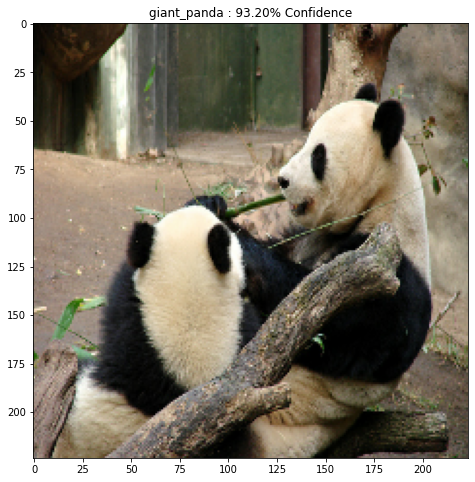

In [11]:
plt.figure()
plt.imshow(image[0] * 0.5 + 0.5)  # To change [-1, 1] to [0,1]
_, image_class, class_confidence = get_imagenet_label(image_probs)
plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100))
plt.show()

## Create the Adversarial Image. 

We use the FGSM method to create an adversarial image. Be sure to read about FGSM to understand how the attack works. 

In [12]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = pretrained_model(input_image)
    loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad

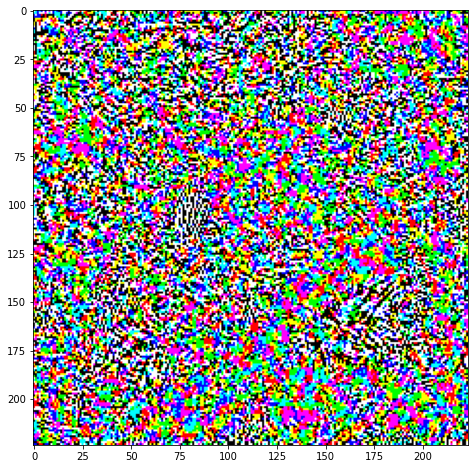

In [13]:
# Get the input label of the image.
giant_panda_index = 388
label = tf.one_hot(giant_panda_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]

In [14]:
def display_images(image, description):
  _, label, confidence = get_imagenet_label(pretrained_model.predict(image))
  plt.figure()
  plt.imshow(image[0]*0.5+0.5)
  plt.title('{} \n {} : {:.2f}% Confidence'.format(description,
                                                   label, confidence*100))
  plt.show()

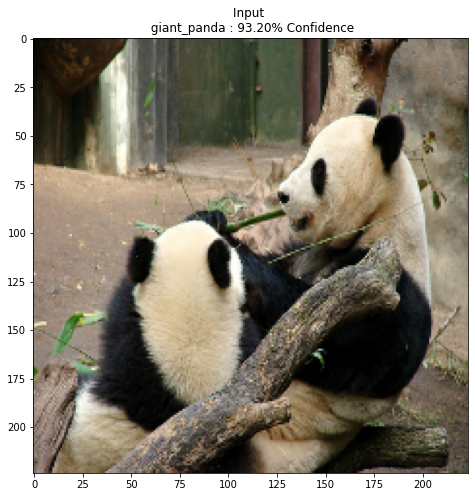

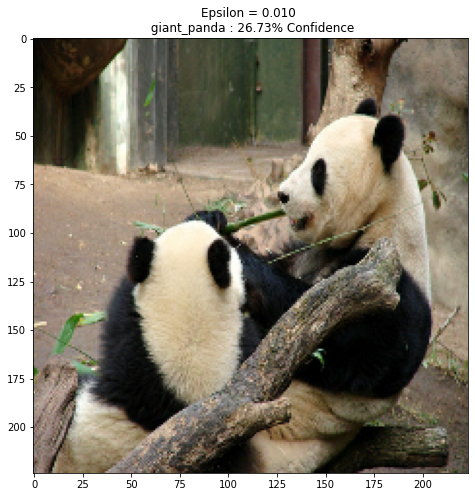

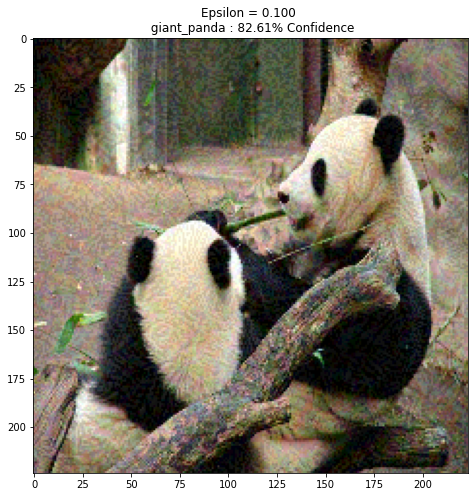

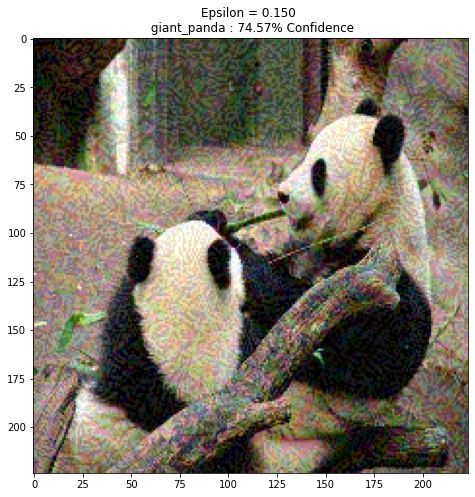

In [15]:
epsilons = [0, 0.01, 0.1, 0.15]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)
  display_images(adv_x, descriptions[i])

# Task2: Perform an Analysis to understand the potency of the attack. 

Your task here is to understand how small a change could change the class output and this is measured by the epsilon value needed to change the class. 

Your task is as follows:

* Pick 10 images each from different classes in imagenet. 
* Perform a perturbation analysis on each of these images. 
* In the analysis you are required to report the smallest epsilon value for which you notice a class change. 
* Make a table for each of the images considered with the minimum epsilon value for the FGSM attack. 

Write the Code for the above below. You can add the table also below. 

In [102]:
file_paths = [
              { 'path': '/images/n01440764_tench.JPEG', 'index': '0'},
              { 'path': '/images/n01443537_goldfish.JPEG', 'index': '1'},
              { 'path': '/images/n02841315_binoculars.JPEG', 'index': '447'},
              { 'path': '/images/n01491361_tiger_shark.JPEG', 'index': '3'},
              { 'path': '/images/n04023962_punching_bag.JPEG', 'index': '747'},
              { 'path': '/images/n04285008_sports_car.JPEG', 'index': '817'},
              { 'path': '/images/n02974003_car_wheel.JPEG', 'index': '479'},
              { 'path': '/images/n02782093_balloon.JPEG', 'index': '417'},
              { 'path': '/images/n03124043_cowboy_boot.JPEG', 'index': '514'},
              { 'path': '/images/n01580077_jay.JPEG', 'index': '17'},
              ]

def create_adversarial_pattern_input_model(input_image, input_label, pretrained_model):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = pretrained_model(input_image)
    loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad

def get_image_name(path):
  return path[path.index('_') + 1:path.index('.')]


def preprocess_image(image, preprocess_alt, preprocess_size):
  image = tf.cast(image, tf.float32)
  # print(preprocess_size)
  image = tf.image.resize(image, preprocess_size)
  image = preprocess_alt(image)
  image = image[None, ...]
  return image

def get_images(pretrained_model, file_paths, preprocess_alt, preprocess_size):
  finished_images = []
  for file in file_paths:
    image_raw = tf.io.read_file(file['path'])
    image = tf.image.decode_image(image_raw)
    image = preprocess_image(image, preprocess_alt, preprocess_size)
    image_probs = pretrained_model.predict(image)
    image_name = get_image_name(file['path'])
    image_index = file['index']
    # print(image_index)
    finished_images.append((image, image_probs, image_name, image_index))
  # print(finished_images)
  return finished_images

def perturbation_maker(finished_images, pretrained_model):
  perturbations = []
  for image_data in finished_images:
    # print(image_data)
    image, image_probs, image_name, image_index = image_data
    # print(image_index)

    label = tf.one_hot(int(image_index), image_probs.shape[-1])
    label = tf.reshape(label, (1, image_probs.shape[-1]))

    perturbations.append(create_adversarial_pattern_input_model(image, label, pretrained_model))
  return perturbations

# keep track of the number of decimal places we want to end at, more decimal places is slower
# but more places is more accurate
DECIMAL_PLACES = 3
def epsilon_binary_search(correct_label, image, pretrained_model, perturbations):
  epsilon = 0.0
  left = 0.0
  right = 1.0
  prev_epsilon = 1.0

  i = 0
  # prevent infinite loops by giving a large constant iteration limit
  while (i < 100):
    epsilon = (left + right) / 2

    if round(epsilon, DECIMAL_PLACES) == round(prev_epsilon, DECIMAL_PLACES):
      # print("Found Epsilon:" + str(epsilon))
      break
    prev_epsilon = epsilon

    # add perturbations to the image
    adv_x = image + epsilon * perturbations
    adv_x = tf.clip_by_value(adv_x, -1, 1)
    _, label_prediction, confidence = get_imagenet_label(pretrained_model.predict(adv_x))

    # print(label_prediction)
    # print(correct_label)
    if label_prediction != correct_label:
      right = epsilon
    else: 
      left = epsilon
    
    # print("Binary Search: " + str(i))
    i = i + 1
  return round(epsilon + 0.0005, DECIMAL_PLACES)

def epsilon_finder_all(finished_images, pretrained_model, perturbations, epsilon_dict):
  i = 0
  for image_data in finished_images:
    image, image_probs, image_name, image_index = image_data
    epsilon = epsilon_binary_search(image_name, image, pretrained_model, perturbations[i])

    if image_name not in epsilon_dict:
      epsilon_dict[image_name] = [epsilon]
    else:
      epsilon_dict[image_name].append(epsilon)
    # print(i)
    i = i + 1
  return epsilon_dict


  



In [103]:
def task2_runner(pretrained_model, preprocess_alt, preprocess_size, epsilon_dict):
  image_data = get_images(pretrained_model, file_paths, preprocess_alt, preprocess_size)
  # print(image_data)
  image_p = perturbation_maker(image_data, pretrained_model)

  min_epsilon = epsilon_finder_all(image_data, pretrained_model, image_p, epsilon_dict)
  print (min_epsilon)
  return min_epsilon

def task2_runner_main():

  pretrained_model = tf.keras.applications.MobileNetV2(include_top=True, weights='imagenet')
  pretrained_model.trainable = False
  min_epsilon = task2_runner(pretrained_model, tf.keras.applications.mobilenet_v2.preprocess_input, (224, 224), {})
  global task2
  task2 = min_epsilon
  make_table(min_epsilon, ['MobileNetV2'])
  return

# import traceback
# try: 
task2_runner_main()
# except:
  # traceback.print_exc()

{'tench': [0.131], 'goldfish': [0.23], 'binoculars': [0.151], 'tiger_shark': [0.097], 'punching_bag': [0.004], 'sports_car': [0.003], 'car_wheel': [0.143], 'balloon': [0.235], 'cowboy_boot': [0.155], 'jay': [0.063]}


In [120]:
import pandas as pd

In [121]:
def make_table(epsilon_dict, index_val):
  epsilon_minimums = pd.DataFrame(epsilon_dict.values())
  # Transpose the values so the epsilons are listed horizontally in table
  epsilon_minimums_transpose = epsilon_minimums.transpose()
  epsilon_processed = epsilon_minimums_transpose.values.tolist()

  df = pd.DataFrame(epsilon_processed, index=index_val, columns=epsilon_dict.keys())
  df.columns.name = 'Object Type'
  df.index.name = 'Model Type'
  return df


print(make_table(task2, ['MobileNetV2']))

Object Type  tench  goldfish  binoculars  tiger_shark  punching_bag  \
Model Type                                                            
MobileNetV2  0.131      0.23       0.151        0.097         0.004   

Object Type  sports_car  car_wheel  balloon  cowboy_boot    jay  
Model Type                                                       
MobileNetV2       0.003      0.143    0.235        0.155  0.063  


# Task3: Compare the robustness of the considered model with other models. 

Your task here is to compare how this model (MobileNetV2) compares with other popular object detection models. 

Your task is as follows:

* Consider 5 different models (you can consider various RESNET architectures, any models you find interesting).
* Load the pre-trained weights of the model (trained on imagenet). 
* Perform Task2 on all the considered models. 
* Add all the results in the table. Hence the final table you have 6 columns for each model and epsilon values for each of the 10 images for all 6 models. 


What do you observe? Why do you think this is the case? 

Write the Code for the above below. You can also add the table and answer to the question below. 


In [40]:
  models = [
              (tf.keras.applications.InceptionV3(include_top=True, weights='imagenet'), (299, 299), 'inception_v3', 'InceptionV3'),
              (tf.keras.applications.Xception(include_top=True, weights='imagenet'), (299, 299), 'xception', 'Xception'),
              (tf.keras.applications.MobileNetV2(include_top=True, weights='imagenet'), (224, 224), 'mobilenet_v2', 'MobileNetV2'), 
              (tf.keras.applications.NASNetMobile(include_top=True, weights='imagenet'), (224, 224), 'nasnet', 'NASNetMobile'),
              (tf.keras.applications.ResNet50V2(include_top=True, weights='imagenet'), (224, 224), 'resnet_v2', 'ResNetV2'),
              (tf.keras.applications.ResNet152V2(include_top=True, weights='imagenet'), (224, 224), 'resnet_v2', 'ResNet152V2'),
            ]

  

In [122]:
# from tensorflow.python.framework.ops import name_scope_v1

def task3_runner():
  index_val = []
  epsilon_dict = {}
  for (model, model_size, name1, name2) in models:
    model.trainable = False
    application = getattr(tf.keras.applications, name1)
    decode_predictions = application.decode_predictions
    
    index_val.append(name2)
    preprocess_alt = application.preprocess_input
    # print(model_size)
    
    # Perform task 2 on new model
    print("Model attack start: ", name2),
    epsilon_dict = task2_runner(model, preprocess_alt, model_size, epsilon_dict)
  
  print(make_table(epsilon_dict, index_val))

import traceback
try: 
  task3_runner()
except:
  traceback.print_exc()

Model attack start:  InceptionV3
{'tench': [0.668], 'goldfish': [0.51], 'binoculars': [0.666], 'tiger_shark': [0.294], 'punching_bag': [0.274], 'sports_car': [0.001], 'car_wheel': [0.68], 'balloon': [0.431], 'cowboy_boot': [0.604], 'jay': [0.445]}
Model attack start:  Xception
{'tench': [0.668, 0.003], 'goldfish': [0.51, 0.445], 'binoculars': [0.666, 0.214], 'tiger_shark': [0.294, 0.315], 'punching_bag': [0.274, 0.438], 'sports_car': [0.001, 0.411], 'car_wheel': [0.68, 0.646], 'balloon': [0.431, 0.446], 'cowboy_boot': [0.604, 0.659], 'jay': [0.445, 0.37]}
Model attack start:  MobileNetV2
{'tench': [0.668, 0.003, 0.131], 'goldfish': [0.51, 0.445, 0.23], 'binoculars': [0.666, 0.214, 0.151], 'tiger_shark': [0.294, 0.315, 0.097], 'punching_bag': [0.274, 0.438, 0.004], 'sports_car': [0.001, 0.411, 0.003], 'car_wheel': [0.68, 0.646, 0.143], 'balloon': [0.431, 0.446, 0.235], 'cowboy_boot': [0.604, 0.659, 0.155], 'jay': [0.445, 0.37, 0.063]}
Model attack start:  NASNetMobile
{'tench': [0.668, 

# BONUS: Can you provide a better attack?

Can you design a better attack that lowers the epsilon required for the images?

Task:

* Design another attack. 
* Compare the epsilon values on 10 images. 
* Does it perform better than the FGSM attack? That is, does it have lower epsilon values?

Write the code and provide your answers below. 